In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import import_ipynb
from equalize_dates_tests_UNUSED import df_refugees, df_prices, df_equipment, df_personnel
from clean_tests import index_by_datetime, decumulate_columns


1) Se espera que los precios en Ucrania oscilen en función del número de refugiados que huyen del país y de la cercanía al frente de los puestos de venta. Asimismo, un peor rendimiento por parte del bando ruso debería animar a los proveedores a vender en el país y aumentar la oferta.

Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos

Necesito:

1) Dataframe de precios-longitudes para comparar si + lejanía del frente = precios + bajos:

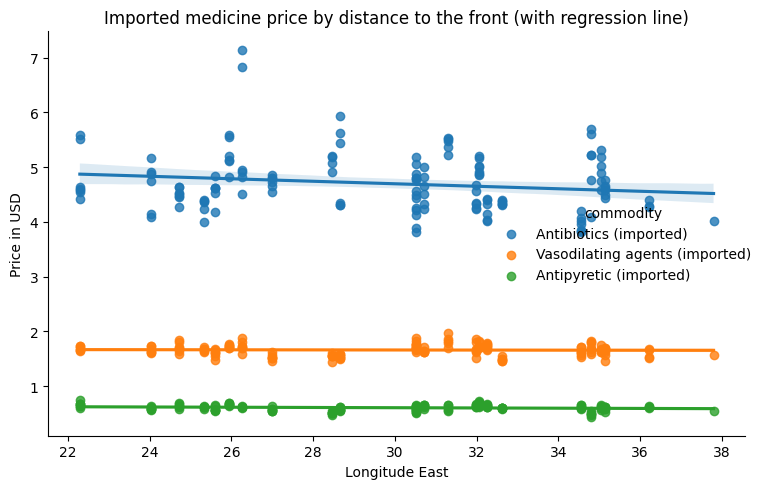

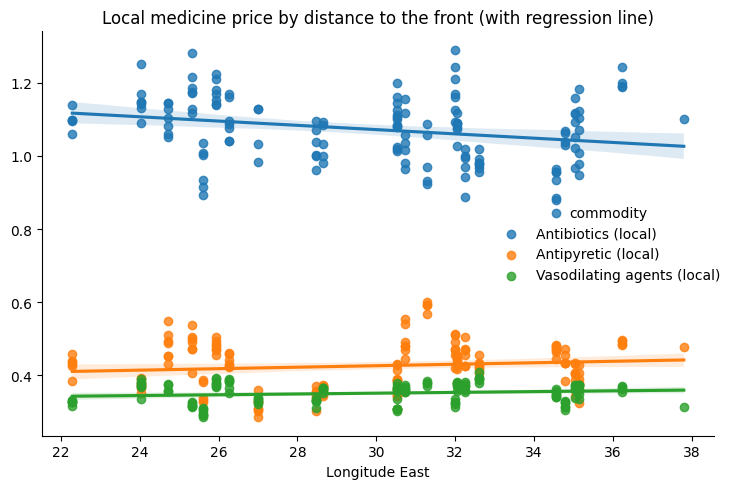

In [3]:
# Checks if the values of a column in a dataframe contain a string and creates a new dataframe based on that values. 
# Then, returns a list of lists the chosen columns of that new dataframe as well as the dataframe itelf
def extract_columns_if_value(dataframe, check_strs, check_column, final_columns):
    '''Requires a dataframe, a string or strings to check (list of strings), a column (string) to look for the string, 
    and a list of the final columns to be returned (list of strings)'''
    final_list = []
    for check_str in check_strs:
        if len(check_str.split()) > 1:
            df = dataframe[dataframe[check_column] == check_str]
        else:
            df = dataframe[dataframe[check_column].str.contains(check_str)]
        pre_final_list = [df[column] for column in final_columns]
        pre_final_list.append(df)
        final_list.append(pre_final_list)
    return final_list


imported_longitude, imported_price, df_prices_imported = extract_columns_if_value(df_prices, ['imported'], 'commodity', ['longitude_east (degrees)', 'usdprice'])[0]
longitude, price, df_prices_local = extract_columns_if_value(df_prices, ['local'], 'commodity', ['longitude_east (degrees)', 'usdprice'])[0]


# Creates a seaborn lmplot with regression lines using a few default values.
def creates_lmplot_w_regression_line(data, x="longitude_east (degrees)", y="usdprice", hue="commodity", xlabel='Longitude East', ylabel=None, title=None):
    '''Requires a dataframe and two column names. Other parameters are optional and homonym to the ones used in a seaborn lmplot'''
    sns.lmplot(data=data, x=x, y=y, hue=hue)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()  

creates_lmplot_w_regression_line(df_prices_imported, ylabel='Price in USD', title='Imported medicine price by distance to the front (with regression line)')
creates_lmplot_w_regression_line(df_prices_local, title='Local medicine price by distance to the front (with regression line)')



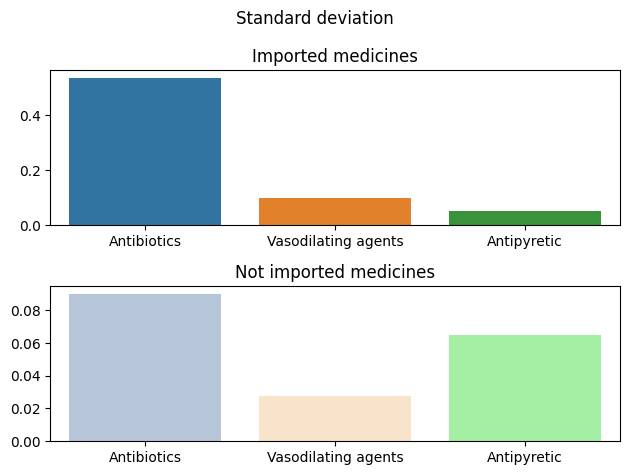

In [4]:
imported_med_usd_list = extract_columns_if_value(df_prices_imported, 
                                                ['Antibiotics (imported)', 'Vasodilating agents (imported)', 'Antipyretic (imported)'], 
                                                'commodity', 
                                                ['usdprice']
                                                )

local_med_usd_list = extract_columns_if_value(df_prices_local, 
                                                ['Antibiotics (local)', 'Vasodilating agents (local)', 'Antipyretic (local)'], 
                                                'commodity', 
                                                ['usdprice']
                                                )
# Esto es un groupby...

df_imp_antibiotics, df_imp_vasodilating, df_imp_antipyretic = imported_med_usd_list
df_antibiotics, df_vasodilating, df_antipyretic = local_med_usd_list


plt.subplot(2, 1, 1)
sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[df_imp_antibiotics[0].std(), df_imp_vasodilating[0].std(), df_imp_antipyretic[0].std()])
plt.title('Imported medicines')
plt.subplot(2, 1, 2)
sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[df_antibiotics[0].std(), df_vasodilating[0].std(), df_antipyretic[0].std()], 
                                                                    palette = ['lightsteelblue','bisque', 'palegreen']
            )
plt.title('Not imported medicines')
plt.suptitle('Standard deviation')
plt.tight_layout()
plt.show()


In [5]:
# No hay una relación entre la distancia al frente y el precio de las medicinas. 
# El precio de las medicinas locales oscila mucho, lo que hace pensar que no hay un suministro estable.
# Ocurre lo mismo con los antibióticos de importación, cuya desviación estándar es muy superior a las otras importadas.
# La medicina de importación es mucho más cara que la local, y el efecto es mucho mayor en el caso de los antibióticos.
# Todo parece apuntar a que las medicinas locales son escasas, y, de las de importación, los antibióticos son los primeros en acabarse.
# Con estos indicios cabría comprobar si el suministro de antibióticos es suficiente y, en caso contrario, aumentar su importación.


In [6]:
'''Calculates the gini coefficient for a dataframe column. Returns the coefficient as well as a dataframe with the corresponding calculations'''
def calculate_gini(dataframe, x_column):
    '''Requires a dataframe and the name of a column of numeric values'''
    dataframe = dataframe.copy()
    dataframe.insert(0, 'x_column_counts', 1)
    dataframe = dataframe.groupby(x_column).count()
    dataframe = dataframe.reset_index()
    dataframe.rename(columns={x_column:'xi','x_column_counts':'ni'}, inplace=True)
    dataframe = dataframe[['xi','ni']]
    dataframe['Ni'] = dataframe['ni'].cumsum()
    n = float(dataframe['Ni'][-1:])
    dataframe['xi·ni'] = dataframe['xi'] * dataframe['ni']
    dataframe['ui'] = dataframe['xi·ni'].cumsum()
    bigger_ui = float(dataframe['ui'][-1:])
    dataframe['pi'] = dataframe['Ni'] / n
    dataframe['qi'] = dataframe['ui'] / bigger_ui
    gini = 1 - sum(dataframe['qi'][:-1]) / sum(dataframe['pi'][:-1])
    return gini, dataframe



In [7]:
imported_med_usd_list

[[date
  2022-03-15    4.8148
  2022-03-15    4.0917
  2022-03-15    3.8309
  2022-03-15    4.2336
  2022-03-15    4.1824
                 ...  
  2022-09-15    4.4358
  2022-09-15    5.1818
  2022-09-15    4.3019
  2022-09-15    4.4045
  2022-09-15    4.8066
  Name: usdprice, Length: 138, dtype: float64,
              usdprice        market               commodity  \
  date                                                         
  2022-03-15    4.8148         Rivne  Antibiotics (imported)   
  2022-03-15    4.0917          Sumy  Antibiotics (imported)   
  2022-03-15    3.8309       Poltava  Antibiotics (imported)   
  2022-03-15    4.2336         Odesa  Antibiotics (imported)   
  2022-03-15    4.1824      Ternopyl  Antibiotics (imported)   
  ...              ...           ...                     ...   
  2022-09-15    4.4358          Kyiv  Antibiotics (imported)   
  2022-09-15    5.1818     Kyiv city  Antibiotics (imported)   
  2022-09-15    4.3019       Kherson  Antibiotics (im

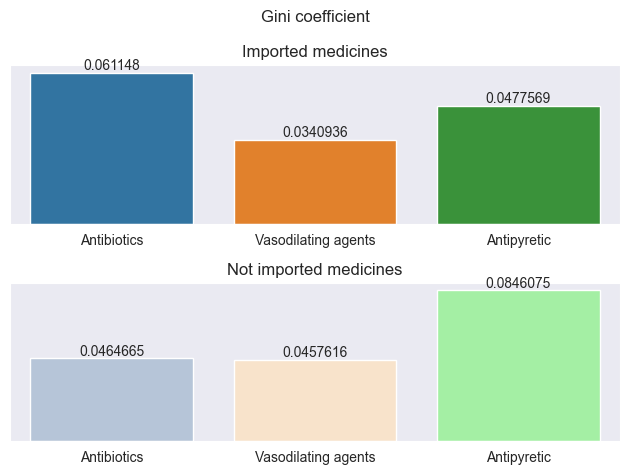

In [8]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(2)
    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(imported_med_usd_list[0][1], 'usdprice')[0], 
                                                                        calculate_gini(imported_med_usd_list[1][1], 'usdprice')[0], 
                                                                        calculate_gini(imported_med_usd_list[2][1], 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[0]
                )
    ax[0].set_title('Imported medicines')

    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(local_med_usd_list[0][1], 'usdprice')[0], 
                                                                        calculate_gini(local_med_usd_list[1][1], 'usdprice')[0], 
                                                                        calculate_gini(local_med_usd_list[2][1], 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[1],
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
                )

    for number in range (0,2):
        for i in ax[number].containers:
            ax[number].set_yticks([])
            ax[number].bar_label(i,)

    ax[1].set_title('Not imported medicines')
    fig.suptitle('Gini coefficient')

    fig.tight_layout()
    plt.show()


In [9]:
# El índice de Gini es muy bajo para todos los medicamentos, lo cual indica que el precio es bastante equitativo en todos los casos.
# Así, aunque las múltiples diferencias pueden ser sintomáticas de oscilaciones en la oferta-demanda, son pequeñas como para que la desigualdad se note en el bolsillo del consumidor.

2) Dataframe de precios-bajas para comparar si + bajas = precios + bajos. Las bajas que coincidan con las fechas del dataframe de precios deben representar el total de bajas del mes anterior (hasta la fecha previa):

In [10]:
df_personnel

,personnel
date,
2022-03-15,1500
2022-03-16,300
2022-03-17,200
2022-03-18,200
2022-03-19,200
...,...
2022-09-11,400
2022-09-12,300
2022-09-13,350


In [11]:
# Based on a dataframe with a datetime index, creates a single column dataframe with an index by month containing the sum of the values of each previous interval. 
# Returns the same dataframe with a datetime index and an integer index
def date_index_to_monthly(dataframe, column_init, column_final, new_index):
    '''Requires a dataframe with a datetime index, the column to sum (string), the name of the column in the final dataframe (string), 
    and a list with the months of the new index (list of datetimes)'''
    losses_list = []
    for date in new_index:
        monthly_changes = dict()
        previous_date = date - relativedelta(months=1)
        df_rango = dataframe[(dataframe.index < date) & (dataframe.index >= previous_date)]
        changes_of_month = sum(df_rango[column_init])
        monthly_changes[column_final] = changes_of_month
        losses_list.append(monthly_changes)
    df_monthly = pd.DataFrame(losses_list)
    df_monthly_int_index = df_monthly.copy()
    df_monthly.index = new_index
    df_monthly_int_index.index = [str(period.month) for period in new_index]
    return df_monthly, df_monthly_int_index

datetimes_to_study = df_prices.index.drop_duplicates()
df_monthly_personnel_datetime, df_monthly_personnel = date_index_to_monthly(df_personnel, 'personnel', 'Personnel losses', datetimes_to_study[1:])
df_monthly_equipment_datetime, df_monthly_equipment =  date_index_to_monthly(df_equipment, 'total losses', 'Equipment losses', datetimes_to_study[1:])


In [12]:
df_prices

,usdprice,market,commodity,longitude_east (degrees)
date,,,,
2022-03-15,4.8148,Rivne,Antibiotics (imported),26.2516
2022-03-15,1.0399,Rivne,Antibiotics (local),26.2516
2022-03-15,0.4625,Rivne,Antipyretic (local),26.2516
2022-03-15,1.5907,Rivne,Vasodilating agents (imported),26.2516
2022-03-15,0.3667,Rivne,Vasodilating agents (local),26.2516
...,...,...,...,...
2022-09-15,1.1268,Khmelnytskiy,Antibiotics (local),26.9871
2022-09-15,0.6332,Khmelnytskiy,Antipyretic (imported),26.9871
2022-09-15,0.3591,Khmelnytskiy,Antipyretic (local),26.9871


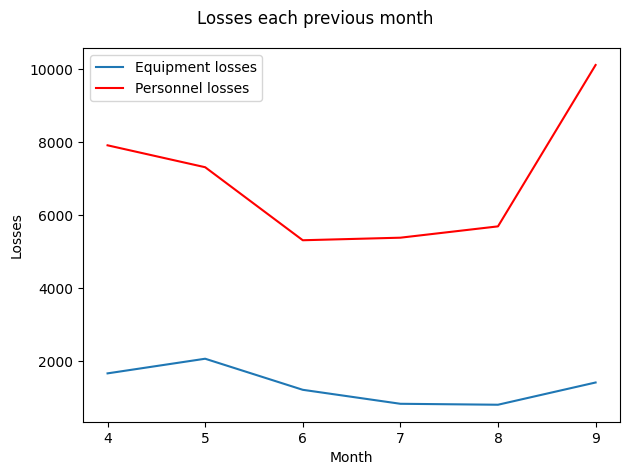

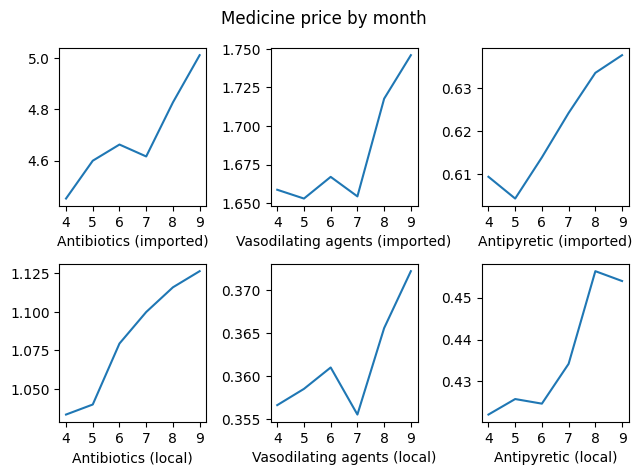

In [13]:
sns.lineplot(df_monthly_equipment)
sns.lineplot(df_monthly_personnel, palette=['r'])
plt.ylabel(ylabel="Losses")
plt.xlabel(xlabel="Month")
plt.suptitle('Losses each previous month')
plt.tight_layout()
plt.show()


commodities = ['Antibiotics (imported)', 'Vasodilating agents (imported)', 'Antipyretic (imported)', 'Antibiotics (local)',  'Vasodilating agents (local)', 'Antipyretic (local)']

df_prices_monthly = df_prices.copy()
df_prices_monthly.drop(columns='longitude_east (degrees)', inplace=True)


# Limits a dataframe by a column value, applies a groupby index, aggregates it by mean by default (median may be preferred) and drops some of the index values (or none)
def applies_where_groupby_mean_drop(dataframe, column, index_name, value, index_drops=None, median=False):
    '''Requires a dataframe, a column name (string), an index name (string) and value to look for. Accepts a list of index values and a boolean type as optional key arguments'''
    dataframe = dataframe[dataframe[column] == value]
    if median:
        dataframe = dataframe.groupby(index_name).median(numeric_only=True)
    else:
        dataframe = dataframe.groupby(index_name).mean(numeric_only=True)
    if index_drops[0]:
        dataframe.drop(index=index_drops, inplace=True)
    return dataframe


count = 0
for element in commodities:
    df_prices_monthly_single_med = applies_where_groupby_mean_drop(df_prices_monthly, 'commodity', 'date', element, index_drops=['2022-03-15'], median=True)
    df_prices_monthly_single_med.index = ['4', '5', '6', '7', '8', '9']
    count +=1
    plt.subplot(2, 3, count)
    sns.lineplot(df_prices_monthly_single_med)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=element)
plt.suptitle('Medicine price by month')
plt.tight_layout()
plt.show()


In [14]:
# Aunque las pérdidas humanas y de equipamiento siguen una tendencia similiar según los gráficos (se 'hunden' por la derecha),
# también es cierto que la curva del equipamiento parece menos pronunciada.
# Lo comprobamos:

print(df_monthly_equipment.skew())
print(df_monthly_personnel.skew())


# Como la curva de personal es la más asimétrica por la derecha, si bien son similares, la preferiremos por ser más pronunciado el desequilibio,
# pues suponemos que dará unos resultados más claros.


Equipment losses    0.401188
dtype: float64
Personnel losses    0.989514
dtype: float64


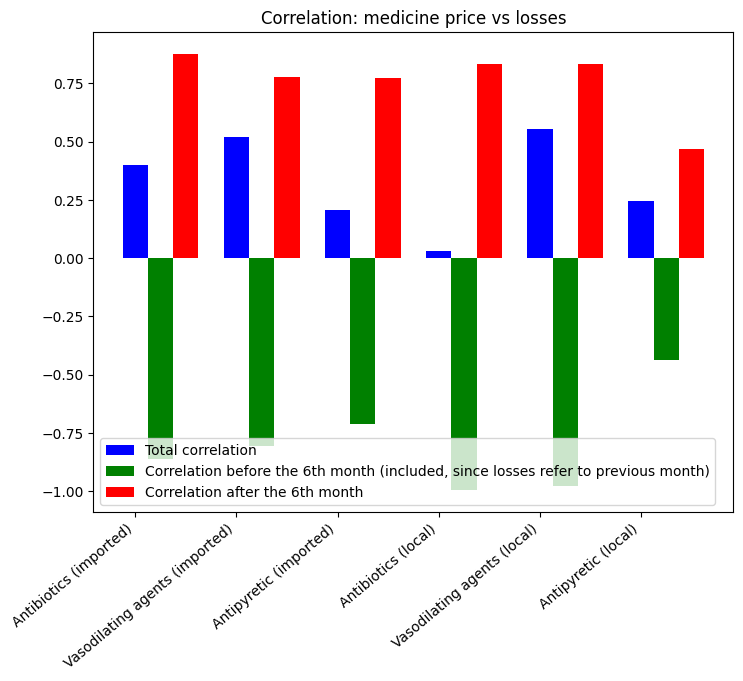

In [15]:
# Calculamos la correlación para cada medicamento respecto a las pérdidas de personal.
# Como vemos que en el punto 6 se producen cambios importantes sen todas las gráficas, calcularemos también la correlación antes y a partir de ese punto.
# Las representaremos las tres juntas en un gráfico

total_index_drops = [['2022-03-15'], ['2022-03-15', '2022-07-15', '2022-08-15', '2022-09-15'], ['2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15']]

corr_vectors = []
for index_drops in total_index_drops:
       corr_vector = []
       for element in commodities:
              df_prices_monthly_single_med = applies_where_groupby_mean_drop(df_prices_monthly, 'commodity', 'date', element, index_drops=index_drops, median=True)
              df_price_personnel = df_prices_monthly_single_med.merge(df_monthly_personnel_datetime, left_index=True, right_index=True)
              corr_vector.append(df_price_personnel.corr()['usdprice'][1])
       corr_vectors.append(corr_vector)


X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, corr_vectors[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, corr_vectors[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, corr_vectors[2], color = 'r', width = 0.25)
plt.xticks([0, 1, 2, 3, 4, 5], commodities)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(labels=['Total correlation', 'Correlation before the 6th month (included, since losses refer to previous month)', 'Correlation after the 6th month'])
plt.title('Correlation: medicine price vs losses')
plt.show()


In [16]:
# Vemos que la correlación cambia totalmente de sentido en ambos casos, y lo hace de manera contundente. Podemos concluir, pues:
# - En términos generales, las bajas y los medicamentos están inversamente correlacionados, aunque de un modo poco tajante
# - Antes del mes 6, van en la dirección contraria
# - Sin embargo partir del mes 6, van en la misma, y se vuelve muy palpable
# - La hipótesis 2 estudia las bajas personales comparadas con las de equipamiento. Será interesante ver qué ocurre el mes 6 para que se produzca tal cambio


3) Dataframe de precios-refugiados para comparar si + refugiados = precios + bajos:

In [17]:
df_refugees

,country,individuals
date,,
2022-03-01,Belarus,341
2022-03-01,Poland,453982
2022-03-01,Slovakia,67000
2022-03-01,Republic of Moldova,79315
2022-03-01,Hungary,116348
...,...,...
2022-09-10,Republic of Moldova,606707
2022-09-11,Belarus,16705
2022-09-13,Hungary,1381738


In [18]:
len(df_refugees.index)

491

In [19]:
# Conditions a datetime-indexed dataframe, for each datetime in the supplied list, with the duplicated values of the chosen column of strings. 
# If one is not found for a certain datetime, looks for it at the next existent datetime (default increase = 1 day).
# In the subsequent table, sums the corresponding values for each datetime in the chosen column of numeric values, and returns a two-column dataframe that equates each sum to their index-datetime
def sum_by_duplicated_values_and_datetime(dataframe, duplicated_column, sum_colum, datetime_list, days_increase=1):
    '''Requires positional arguments: dataframe with datetime indexes, the name (string) of a column of strings, the name (string) of a numeric column and a list of datetimes
    Accepts an integer as a key argument (default is 1)'''
    duplicated_list = dataframe[duplicated_column].drop_duplicates() # lista de ubicaciones posibles
    pre_dataframe_list = []
    for date in datetime_list: # por cada mes en la lista de meses que estudiamos (hay 6, pero el último se ignora por falta de datos)...
        current_date = date # lo asignamos a una variable
        current_sum_list = [] # creamos una lista vacía de individuos
        current_duplicated_list = [] # creamos una lista vacía de ubicaciones
        print(f'Now checking for {date}')
        while len(current_duplicated_list) != len(duplicated_list): # mientras la lista de ubicaciones sea inferior a la lista de ubicaciones posibles...
            try: # que intente lo siguiente:
                current_table = dataframe.loc[[date], [duplicated_column, sum_colum]] # asignar a una variable current table, de df_refugees, las filas country-individuals que correspondan a la fecha
                if current_duplicated_list: # si hay alguna cosa en la lista de ubicaciones...
                    missing_duplicates = list(set(duplicated_list) - set(current_duplicated_list)) # crea una lista de ubicaciones faltantes,  restando a las posibles estas...
                    print(f'Missing: {missing_duplicates}')
                    for duplicate in missing_duplicates: # e itera por las ubicaciones que faltan
                        if duplicate in list(current_table[duplicated_column]):  # si una ubicacion se encuentra en la columna country de la variable current table
                            print(f'{duplicate} found at {date}')
                            current_sum_list.append(int(current_table.loc[current_table[duplicated_column] == duplicate][sum_colum])) # añade el valor de la otra columna a la lista de individuos los correspondientes...
                            current_duplicated_list.append(duplicate) # y la ubicacion a la lista de ubicaciones
                    if len(current_duplicated_list) != len(duplicated_list): # si todavía faltan ubicaciones
                        date += relativedelta(days=days_increase) # cuando termina, suma un día a la fecha para repetir la iteración hasta que salgan todos los duplicates
                        print(f'Add {days_increase} day/s. Current date: {date}')
                else: # si todavía no hay nada en la lista de ubicaciones (es la primera iteración para esa fecha):
                    current_sum_list.append(sum(current_table[sum_colum])) #añade los individuos actuales a su lista
                    current_duplicated_list += list(current_table[duplicated_column]) # añade la ubicación actual a la lista
            except KeyError: # si el try fracasa porque la fecha en concreto no se encuentra en la table y no se puede asignar a la variable current table...
                print(f'{date} does not exist in the dataframe')
                date += relativedelta(days=days_increase) # sumamos un día y repetimos la iteración
                print(f'Add {days_increase} day/s. Current date: {date}')
        current_dict = {'date':current_date, # creamos el diccionario de esta iteración
                        'Total': sum(current_sum_list)
                        }
        pre_dataframe_list.append(current_dict) # añadimos el diccionario a la lista para el dataframe
        print(f'{current_date} has been filled')
    df_total = pd.DataFrame(pre_dataframe_list) # creamos el dataframe con el total por fecha
    return df_total


df_monthly_refugees = sum_by_duplicated_values_and_datetime(df_refugees, 'country', 'individuals', datetimes_to_study[:-1])

decumulate_columns(df_monthly_refugees, excluded='date')
index_by_datetime(df_monthly_refugees, name='date')

df_monthly_refugees.drop(index='2022-03-15', inplace=True) # Borramos el primer índice porque es el acumulado de meses anteriores que no tenemos en la tabla


Now checking for 2022-03-15 00:00:00
2022-03-15 00:00:00 has been filled
Now checking for 2022-04-15 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-04-16 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-04-17 00:00:00
Missing: ['Belarus']
Belarus found at 2022-04-17 00:00:00
2022-04-15 00:00:00 has been filled
Now checking for 2022-05-15 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-16 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-17 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-18 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-19 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-20 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-21 00:00:00
2022-05-21 00:00:00 does not exist in the dataframe
Add 1 day/s. Current date: 2022-05-22 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-23 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 

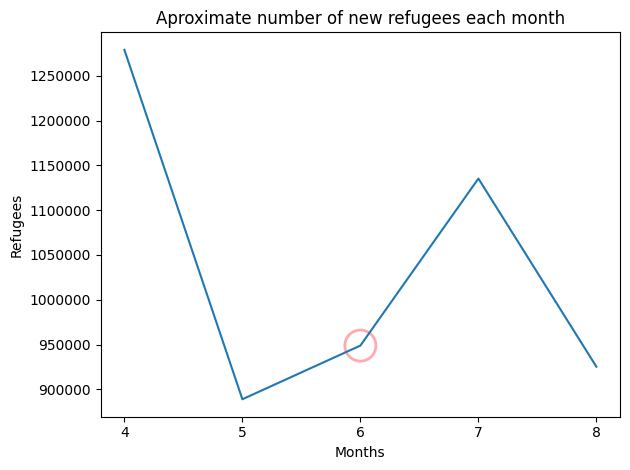

In [20]:
df_monthly_refugees.index = ['4', '5', '6' , '7', '8']

fig, ax = plt.subplots()
ax.scatter(2, 948879, s=500, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_monthly_refugees['Total'], x=df_monthly_refugees.index)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Refugees')
plt.xlabel(xlabel='Months')
plt.title('Aproximate number of new refugees each month')
plt.tight_layout()
plt.show()


In [21]:
# Intuímos que el alto número de refugiados los primeros meses de la guerra son lo esperable al principio de un conflicto de este tipo. 
# Lo interesante, es ver que vuelven a subir después de haber llegado al punto mínimo.
# Como vemos, a partir del mes 6 (marcado) se disparan los refugiados, momento en que las pérdidas rusas, como ya hemos probado, también suben después de un período bajando.
# Probablemente sea un síntoma de que la guerra se recrudece.

Posibles conclusiones finales:

1)
- No hay relación palpable entre la cercanía al frente y el precio de la medicina (la guerra moderna, con artillería de larga distancia y bombardeos, y con un frente poco sólido, implica que todas las ciudades sean susceptibles de sufrir problemas puntuales de suministramiento independientemente de su proximidad al enemigo).
- El precio de la medicina local varía más según el lugar (siendo estos más baratos que los de importación, y tratándose de una situación de guerra, probablemente se produzcan frecuentes desequilibros entre oferta y demanda).
- El precio de la medicina de importación es más estable, excepto en el caso de los antibióticos (siendo estos más caros que los locales, probablemente la gente recurra a ellos cuando los locales no están disponibles, con lo que se producen menos desequilibros entre oferta y demanda que alteren el precio. Por esa razón, los cambios en el precio de los antibióticos importados podrían indicar -siendo estos, además, mucho más caros-, una escasez de antibioticos en general.
- A pesar de ello, es poco probable que las diferencias en el precio de los antibióticos, por sí solas, supongan un problema para los consumidores, ya que el índice de Gini es bajo para todos.

2)
- No hay una relación palpable entre el precio de la medicina y las pérdidas rusas. En términos generales, el precio de la medicina sube, mientras que las pérdidas primero bajan y luego suben.
- Es a partir del mes 6 que las bajas rusas vuelven a subir.

3)
- Los refugiados mensuales se disparan entre el mes 6 y el 7, momento en que hemos visto que las bajas rusas empiezan a subir (es probable que la guerra se recrudezca en este punto).
- En la hipótesis 2 se compararán bajas rusas personales y materiales por fecha. Quizás se encuentren pistas para saber lo que pasa a partir del mes 6.